# COVID-19: Face Mask Recognition

## Submitted by:
## Vitaly Pankratov 961152147
## Eden Bar 318471208

### Link to the github: https://github.com/Stayermax/Face_Mask_Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from  copy import deepcopy
from collections import OrderedDict
import os

import matplotlib.image as mpimg
import pickle

# Exploratory Data Analysis

## Visualization

In [2]:
train_files = os.listdir('train/')
test_files = os.listdir('test/')

print(f"Train-set Size: {len(train_files)}")
print(f"Test-set Size: {len(test_files)}")

Train-set Size: 18259
Test-set Size: 6086


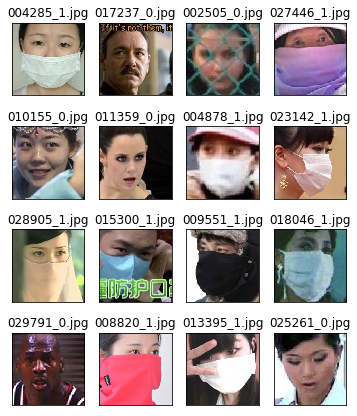

In [3]:
images_num = 16
fig, axs = plt.subplots(4, 4)
for i in range(images_num):
    image = mpimg.imread(f"train/{train_files[i]}")
    axs[int(i/4), i%4].imshow(image)
    plt.xlabel(f"{train_files[i]}")
    axs[int(i / 4), i % 4].title.set_text(f"{train_files[i]}")
    axs[int(i / 4), i % 4].axes.get_xaxis().set_visible(False)
    axs[int(i / 4), i % 4].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
plt.show()

## Insights

We can compare number of masked and unmasked people in the dataset. 

In [4]:
masked_num = 0
unmasked_num = 0
for image_name in train_files:
    if("_1." in image_name):
        masked_num +=1
    elif("_0." in image_name):
        unmasked_num +=1
    else:
        image = mpimg.imread(f"train/{image_name}")
        plt.imshow(image)
plt.show()

print(f"Number of people that wear masks properly in train dataset: {masked_num}")
print(f"Number of people that are not wear masks properly in train dataset: {unmasked_num}")

Number of people that wear masks properly in train dataset: 9948
Number of people that are not wear masks properly in train dataset: 8311


In [5]:
masked_num = 0
unmasked_num = 0
for image_name in test_files:
    if("_1.jpg" in image_name):
        masked_num +=1
    elif("_0.jpg" in image_name):
        unmasked_num +=1
    else:
        image = mpimg.imread(f"train/{image_name}")
        plt.imshow(image)
plt.show()
    
print(f"Number of people that wear masks properly in test dataset: {masked_num}")
print(f"Number of people that are not wear masks properly in test dataset: {unmasked_num}")

Number of people that wear masks properly in test dataset: 3290
Number of people that are not wear masks properly in test dataset: 2796


We can see, that sizes of classes in both datasets are relatively equal, hence we can assume that dataset is balanced.

# Experiments

## Data loading and preprocessing
Loading train dataset into dataframe

In [13]:
train_df_file = 'train_df.pkl'
if (train_df_file in os.listdir('saves/')):
    train_df = pickle.load(open('saves/train_df.pkl', "rb"))
else:
    train_df = pd.DataFrame()
    for image_name in train_files:
        mask = 0
        if ("_1." in image_name):
            mask = 1
        train_df = train_df.append({
            'image': 'train/' + image_name,
            'mask': mask
        }, ignore_index=True)
    pickle.dump(train_df, open('saves/train_df.pkl', "wb"))
print(train_df.head())

test_df_file = 'test_df.pkl'
if (test_df_file in os.listdir('saves/')):
    test_df = pickle.load(open('saves/test_df.pkl', "rb"))
else:
    test_df = pd.DataFrame()
    for image_name in test_files:
        mask = 0
        if ("_1." in image_name):
            mask = 1
        test_df = test_df.append({
            'image': 'test/' + image_name,
            'mask': mask
        }, ignore_index=True)
    pickle.dump(test_df, open('saves/test_df.pkl', "wb"))

print(test_df.head())

                image  mask
0  saves/004285_1.jpg   1.0
1  saves/017237_0.jpg   0.0
2  saves/002505_0.jpg   0.0
3  saves/027446_1.jpg   1.0
4  saves/010155_0.jpg   0.0


In [ ]:
global train_results
global test_results
global prediction_df

train_results = pd.DataFrame(columns=['iteration','loss', 'ROC_AUC', 'f1_score'])
test_results = pd.DataFrame(columns=['iteration','loss', 'ROC_AUC', 'f1_score'])
prediction_df = pd.DataFrame(columns=['image','real_mask', 'predicted_mask'])

#### Data preprocessing class

In [14]:
import cv2
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

class MaskDataset(Dataset):
    """ Masked faces dataset
        0 = 'not correct mask wearing'
        1 = 'correct mask wearing'
    """

    def __init__(self, dataFrame):
        self.dataFrame = dataFrame

        self.transformations = Compose([
            ToPILImage(),
            Resize((100, 100)),
            ToTensor(),  # [0, 1]
        ])

    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')

        row = self.dataFrame.iloc[key]
        return {
            'name': row['image'],
            'image': self.transformations(cv2.imread(row['image'])),
            'mask': tensor([row['mask']], dtype=long),  # pylint: disable=not-callable
        }

    def __len__(self):
        return len(self.dataFrame.index)

## Train

In [19]:
""" Training module
"""
from pathlib import Path
from typing import Dict, List, Union

from PIL import Image
import pytorch_lightning as pl
import torch
import torch.nn.init as init
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader


from report_copy import MaskDetector


In [20]:
def train():
    model = MaskDetector(Path('saves/train_df.pkl'), Path('saves/test_df.pkl'))

    checkpoint_callback = ModelCheckpoint(
        filepath='checkpoints/_ckpt_epoch_9.ckpt',
        save_weights_only=True,
        verbose=True,
        monitor='val_acc',
        mode='max'
    )
    trainer = Trainer(gpus=1 if torch.cuda.is_available() else 0,
                      max_epochs=1,
                      checkpoint_callback=checkpoint_callback,
                      profiler=True)
    

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/home/vitaly/.local/lib/python3.6/site-packages/pytorch_lightning/loggers/tensorboard.py:118: UserWarning: Hyperparameter logging is not available for Torch version 1.2.0. Skipping log_hyperparams. Upgrade to Torch 1.3.0 or above to enable hyperparameter logging.
  f"Hyperparameter logging is not available for Torch version {torch.__version__}."

   | Name             | Type             | Params
--------------------------------------------------
0  | convLayer1       | Sequential       | 896   
1  | convLayer1.0     | Conv2d           | 896   
2  | convLayer1.1     | ReLU             | 0     
3  | convLayer1.2     | MaxPool2d        | 0     
4  | convLayer2       | Sequential       | 18 K  
5  | convLayer2.0     | Conv2d           | 18 K  
6  | convLayer2.1     | ReLU             | 0     
7  | convLayer2.2     | MaxPool2d        | 0     
8  | convLayer3       | Sequential       | 73 K  
9  | conv

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vitaly/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vitaly/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/vitaly/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-14-8c24ed9a0fad>", line 28, in __getitem__
    'image': self.transformations(cv2.imread(row['image'])),
  File "/home/vitaly/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/vitaly/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 110, in __call__
    return F.to_pil_image(pic, self.mode)
  File "/home/vitaly/.local/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 103, in to_pil_image
    raise TypeError('pic should be Tensor or ndarray. Got {}.'.format(type(pic)))
TypeError: pic should be Tensor or ndarray. Got <class 'NoneType'>.
